# A model for the first 340 hours

In [9]:
# initialise:

%run /Users/etc/Projects/201612-lanl-analysis/LANL-analysis/0-lanl-init.ipynb

In [3]:
from __future__ import print_function
from math import log, pow
from collections import Counter

import numpy as np
import re

flows340 = flows.filter(lambda x: x[0]/3600 < 340)
flows340.count()

115394694

In [118]:
def normalise_port(s):
    if re.search('^N', s): return 'N'
    else: return s

def mapper(f, mode='src', binsize=3600):
    ts = f[0]/binsize
    src = f[2]
    dst = f[4]
    dst_pt = normalise_port(f[5])
    proto = f[6]
    nb = f[8]
    if mode=='src':
        return (src, [ts, dst, dst_pt, proto, nb])
    if mode=='dst':
        return (dst, [ts, src, dst_pt, proto, nb])    
    return -1

def reducer(dat, mode='src'):
    """
    where
    dat = [[ts, src/dst, dst_pt, proto, nb],...]
    """
    nr_flows = len(dat)
    nr_bytes = sum([x[4] for x in dat])
    den_flows = float(nr_flows)
    den_bytes = float(nr_bytes)
    
    communicants = set([x[1] for x in dat])
    nr_communicants = len(communicants)
    
    dst_pt_ct = Counter([x[2] for x in dat])
    dst_pt_flows = [(p, k/den_flows) for (p,k) in dst_pt_ct.items()]
    dst_pt_bytes = Counter()
    for i in range(nr_flows):
        dst_pt_bytes[dat[i][2]] += dat[i][4]/den_bytes
        
    proto_ct = Counter([x[3] for x in dat])
    proto_flows = [(p, k/den_flows) for (p,k) in proto_ct.items()]
    proto_bytes = Counter()
    for i in range(nr_flows):
        proto_bytes[dat[i][3]] += dat[i][4]/den_bytes
    
    if(mode=='src'):
        return {'nr_flows_out': nr_flows, 
                'nr_bytes_out': nr_bytes, 
                'nr_dst': nr_communicants,
                'dst_pt_flows_out': dict(dst_pt_flows), 
                'dst_pt_bytes_out': dict(dst_pt_bytes),
                'proto_flows_out': dict(proto_flows),
                'proto_bytes_out': dict(proto_bytes)}
    if(mode=='dst'):
        return {'nr_flows_in': nr_flows, 
                'nr_bytes_in': nr_bytes, 
                'nr_src': nr_communicants,
                'dst_pt_flows_in': dict(dst_pt_flows), 
                'dst_pt_bytes_in': dict(dst_pt_bytes),
                'proto_flows_in': dict(proto_flows),
                'proto_bytes_in': dict(proto_bytes)}
    return -1

        
flows340_src_profile = flows340\
                    .map(lambda x: mapper(x, mode='src', binsize=3600))\
                    .groupByKey()\
                    .map(lambda x: (x[0], reducer(list(x[1]), mode='src')))
flows340_dst_profile = flows340\
                    .map(lambda x: mapper(x, mode='dst', binsize=3600))\
                    .groupByKey()\
                    .map(lambda x: (x[0], reducer(list(x[1]), mode='dst')))
flows340_profile = flows340_src_profile\
                    .join(flows340_dst_profile)\
                    .map(lambda x: (x[0], dict(x[1][0].items() + x[1][1].items())))
flows340_profile.cache()

PythonRDD[258] at RDD at PythonRDD.scala:43

In [189]:
# save as json:

import json
            
filename = lanl_path + "flows340_profile.json"
fp = open(filename, 'w')
json.dump(dict(flows340_profile.collect()), fp)
fp.close()

# show dict keys:
flows340_profile.take(1)[0][1].keys()

['proto_bytes_in',
 'dst_pt_bytes_in',
 'nr_dst',
 'dst_pt_flows_in',
 'proto_bytes_out',
 'dst_pt_flows_out',
 'nr_bytes_in',
 'nr_flows_out',
 'proto_flows_in',
 'dst_pt_bytes_out',
 'nr_src',
 'nr_flows_in',
 'proto_flows_out',
 'nr_bytes_out']

In [144]:
def collect_values(k):
    return flows340_profile\
            .flatMap(lambda x: x[1][k].keys())\
            .distinct()\
            .collect()

dst_pts = collect_values('dst_pt_flows_in')
protos = [1, 6, 17, 41]

print("Dst ports:", len(dst_pts))

Dst ports:  326


In [165]:
from math import log 

def vector(d, keyset):
    fulld = dict([(p,0) for p in keyset])
    for p in d.keys(): fulld[p] = d[p]
    return [fulld[k] for k in sorted(keyset)] # but consider transforming here

def mapper(dat):
    return vector(dat['proto_flows_in'], protos)\
         + vector(dat['proto_flows_out'], protos)\
         + vector(dat['proto_bytes_in'], protos)\
         + vector(dat['proto_bytes_out'], protos)\
         + vector(dat['dst_pt_flows_in'], dst_pts)\
         + vector(dat['dst_pt_flows_out'], dst_pts)\
         + vector(dat['dst_pt_bytes_in'], dst_pts)\
         + vector(dat['dst_pt_bytes_out'], dst_pts)

flows340_profile_vector_rep = flows340_profile\
                                .map(lambda x: (x[0], mapper(x[1])))\
                                .collect()

comp_table = dict(flows340_profile.collect())

In [180]:
from tsne import bh_sne

dat = np.array([x[1] for x in flows340_profile_vector_rep])
proj_2d = bh_sne(dat, theta=0.1)

In [223]:
port = '53'

col = dict([(c,'grey') for c in label])
for c in comp_table.keys():
    if port in comp_table[c]['dst_pt_flows_in'].keys() and\
        port in comp_table[c]['dst_pt_flows_out'].keys(): 
            col[c] = 'blue'
    if port in comp_table[c]['dst_pt_flows_in'].keys():
        col[c] = 'red'
    if port in comp_table[c]['dst_pt_flows_out'].keys(): 
        col[c] = 'green'

col = [col[c] for c in label]

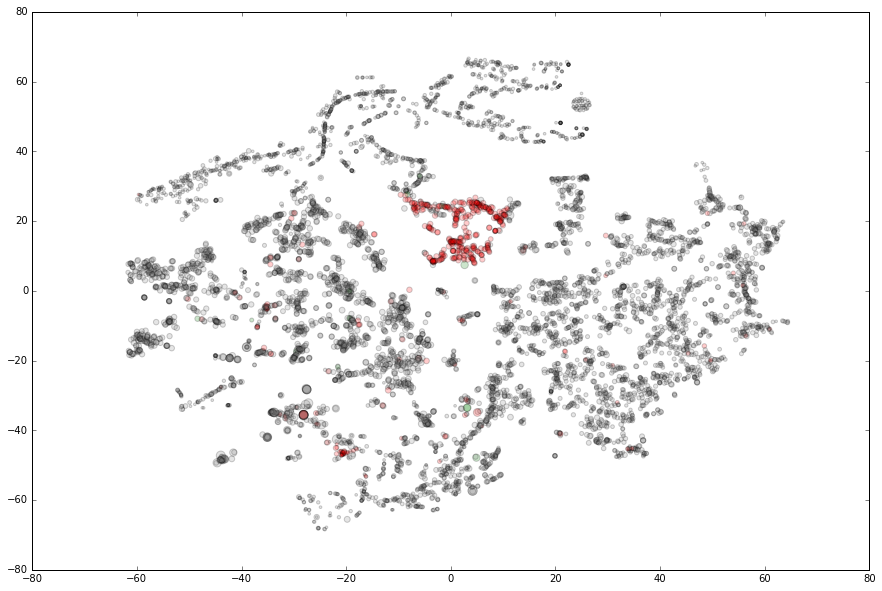

In [224]:
%matplotlib inline
import matplotlib.pyplot as plt

label = [x[0] for x in flows340_profile_vector_rep]
x = proj_2d[:,0]
y = proj_2d[:,1]

dat = flows340_profile\
        .map(lambda x: (x[0], x[1]['nr_dst']))\
        .collect()
tmp = dict(dat)
size = [10*log(tmp[k]) for k in label]

plt.figure(figsize=(15,10))
plt.scatter(x,y, s=size, c=col, alpha=0.2)